In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import (f1_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
full_training_data_wt = pd.read_csv('Nata_Files/processed/train_dataset.csv', index_col=0)
full_testing_data_wt = pd.read_csv('Nata_Files/processed/test_dataset.csv', index_col=0)
full_prediction_data = pd.read_csv('Nata_Files/processed/pred_scaled.csv', index_col=0)

In [8]:
X_train = full_training_data_wt.drop(['oven_temp', 'target'], axis=1) #dropping redundant feature
prediction_data = full_prediction_data.drop('oven_temp', axis=1)
y_train = full_training_data_wt['target']
X_test = full_testing_data_wt.drop(['oven_temp', 'target'], axis=1) #dropping redundant feature
y_test = full_testing_data_wt['target']

### Instantiating and testing the Random Forest with the Hyperparameters from the previous Notebook

In [9]:
rf_best = RandomForestClassifier(n_estimators=100, max_leaf_nodes=164, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_best.fit(X_train, y_train)
print(f"Training Score: {round(100*rf_best.score(X_train, y_train),2)}%\nValidation Score: {round(100*rf_best.score(X_test, y_test),2)}%")

Training Score: 89.64%
Validation Score: 78.65%


## GradientBoostingClassifier - Base Model and Tuning

We evaluated a Gradient Boosting Classifier to see how it compared to our Random Forest. Through a targeted Grid Search, we optimized hyperparameters to address the high variance seen in earlier models. This approach successfully minimized overfitting, providing a more stable model that generalized better to the test dataset.

In [31]:
param_grid={'n_estimators': [100, 300, 500],
            'subsample': [0.25 ,0.5, 0.75, 0.9],
            'max_leaf_nodes': [10, 30, 80, 100],
            'min_weight_fraction_leaf':[0.1, 0.2, 0.4, 0.8, 0.9],
            'max_features': [5,8,None]
            }
gridsrch=GridSearchCV(estimator=GradientBoostingClassifier(random_state=69), param_grid=[param_grid], cv=2)
gridsrch.fit(X_train, y_train)
print(gridsrch.best_estimator_)

GradientBoostingClassifier(max_features=5, max_leaf_nodes=10,
                           min_weight_fraction_leaf=0.1, n_estimators=300,
                           random_state=69, subsample=0.5)


In [32]:
gb_new = GradientBoostingClassifier(max_features=5, max_leaf_nodes=10,
                           min_weight_fraction_leaf=0.1, n_estimators=300,
                           random_state=69, subsample=0.5)
gb_new.fit(X_train, y_train)
print(f"Training Score: {round(100*gb_new.score(X_train, y_train),2)}%\nValidation Score: {round(100*gb_new.score(X_test, y_test),2)}%")

Training Score: 80.31%
Validation Score: 77.79%


In [35]:
def calculate_F1(X_train, y_train, X_test, y_test, interval):
    """
    Trains GradientBoostingClassifiers for different max_leaf_nodes values on
    a fixed training set and evaluates on a fixed test set.
    """
    y_train_mapped = y_train.map({'OK': 1, 'KO': 0})
    y_test_mapped = y_test.map({'OK': 1, 'KO': 0})

    train_results = []
    test_results = []
    for value in interval:
        gb = GradientBoostingClassifier(max_leaf_nodes=int(value),max_features=5,subsample=0.5, min_samples_leaf=1, n_estimators=300, min_weight_fraction_leaf=0.1, random_state=69)
        gb.fit(X_train, y_train_mapped)
        # --- Train Score ---
        train_pred = gb.predict(X_train)
        f1_train = f1_score(y_train_mapped, train_pred)
        train_results.append(round(f1_train, 3))
        # --- Test Score ---
        test_pred = gb.predict(X_test)
        f1_test = f1_score(y_test_mapped, test_pred)
        test_results.append(round(f1_test, 3))

    best_train_index = np.argmax(train_results)
    best_test_index = np.argmax(test_results)

    best_train_value = interval[best_train_index]
    best_test_value = interval[best_test_index]


    print(f'The best F1 score for train is {max(train_results)} with {best_train_value} Max Leaf Nodes')
    print(f'The best F1 score for test is {max(test_results)} with  {best_test_value} Max Leaf Nodes')

    plt.figure(figsize=(10, 6))
    plt.plot(interval, train_results, label="Train F1")
    plt.plot(interval, test_results, label="Test F1")

    plt.xticks(interval)
    plt.legend()
    plt.ylabel("F1 score")
    plt.xlabel('Max Leaf Nodes')
    plt.title(f"Random Forest Performance vs Max Leaf Nodes")
    plt.grid(True)
    plt.show()

The best F1 score for train is 0.851 with 7 Max Leaf Nodes
The best F1 score for test is 0.839 with  6 Max Leaf Nodes


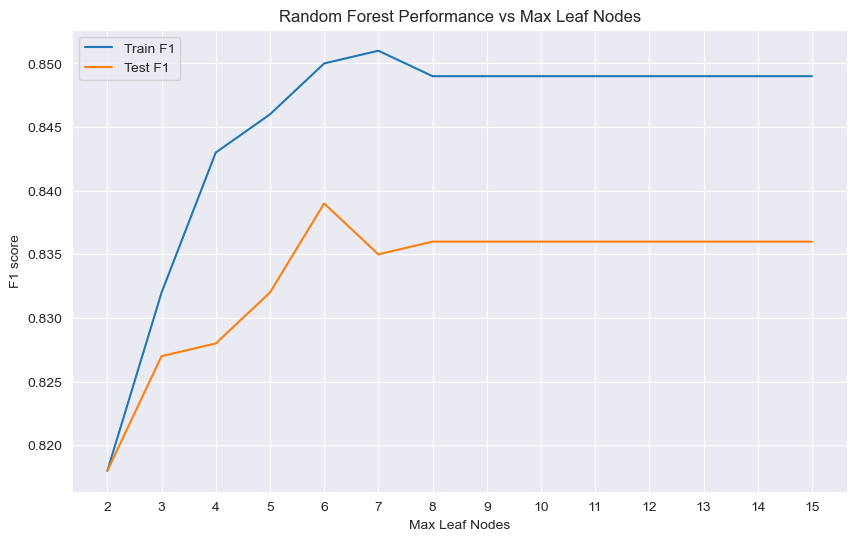

In [36]:
calculate_F1(X_train, y_train,X_test,y_test, np.arange(2, 16))

In [38]:
gb_best = GradientBoostingClassifier(max_leaf_nodes=6,max_features=5,subsample=0.5, min_samples_leaf=1, n_estimators=300, min_weight_fraction_leaf=0.1, random_state=69)
gb_best.fit(X_train,y_train)
gb_best.score(X_train,y_train),gb_best.score(X_test,y_test)
print(f"Training Score: {round(100*gb_best.score(X_train, y_train),2)}%\nValidation Score: {round(100*gb_best.score(X_test, y_test),2)}%")

Training Score: 80.43%
Validation Score: 78.17%


## StackingClassifier - Extra

Following the observation that Gradient Boosting demonstrated comparable performance to the Random Forest with significantly less overfitting, we implemented a StackingClassifier to leverage their combined strengths. This ensemble integrated the Random Forest and Gradient Boosting models with a Logistic Regression meta-learner (utilizing the liblinear solver and an l1 penalty). While this configuration emerged as our most successful model during internal validation, its true generalization capability remained to be verified against the Kaggle competition dataset.

In [39]:
stack = StackingClassifier([('RandomForestClassifier', rf_best), ('GradientBoostingClassifier', gb_best)], final_estimator=LogisticRegression(solver='liblinear', l1_ratio=1))
stack.fit(X_train, y_train)
print(f"Training Score: {round(100*stack.score(X_train, y_train),2)}%\nValidation Score: {round(100*stack.score(X_test, y_test),2)}%")

Training Score: 87.68%
Validation Score: 78.27%


# Final Score Overview and Ranking
Despite exhibiting higher levels of overfitting, the Random Forest consistently outperformed both the GradientBoosting model and the StackingClassifier (which integrated the ensemble trees with a Logistic Regression meta-learner). Based on its superior predictive accuracy on the leaderboard, we have selected the Random Forest as our primary model for the final Kaggle submission and our definitive project conclusion.

In [42]:
gb_pred=gb_best.predict(prediction_data)
gb_pred = pd.Series(gb_pred, index=prediction_data.index)
rf_pred=rf_best.predict(prediction_data)
rf_pred = pd.Series(rf_pred, index=prediction_data.index)
stack_pred = stack.predict(prediction_data)
stack_pred = pd.Series(stack_pred, index=prediction_data.index)
pred_all ={
    'GradientBoosting': gb_pred,
    'RandomForest': rf_pred,
    'StackingClassifier': stack_pred,
}
for name, pred in pred_all.items():
    pred.to_csv(f'Nata_Files/predictions/Final_{name}.csv')

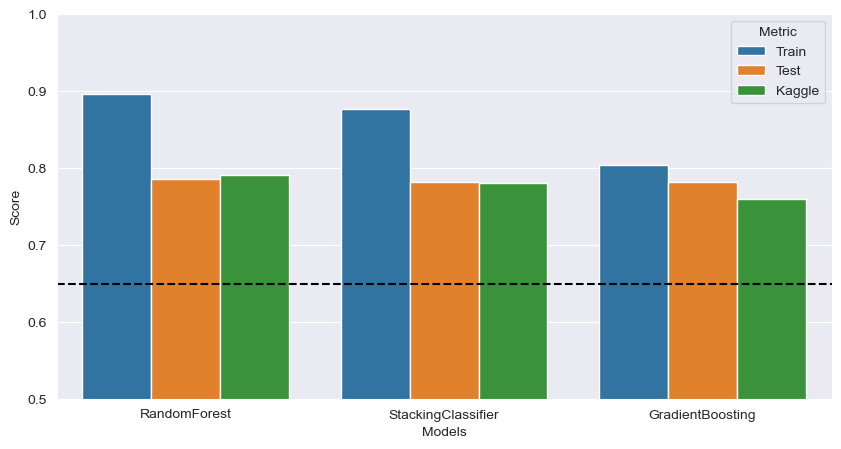

In [41]:
scores = {'GradientBoosting': [gb_best.score(X_train, y_train), gb_best.score(X_test, y_test), 0.76],
          'RandomForest':[rf_best.score(X_train, y_train), rf_best.score(X_test, y_test), 0.791],
          'StackingClassifier':[stack.score(X_train, y_train), stack.score(X_test, y_test), 0.781],
          }
df_scores = pd.DataFrame(scores, index=['Train','Test','Kaggle']).T.reset_index().rename({'index':'Models'}, axis=1)
df_scores.sort_values('Kaggle', ascending=False, inplace=True)
df_long = df_scores.melt(id_vars='Models',
                         value_vars=['Train', 'Test','Kaggle'],
                         var_name='Metric',
                         value_name='Score')
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df_long, x='Models', y='Score', hue='Metric', ax=ax)
plt.ylim(bottom=0.5,top=1)
plt.axhline(y=0.65, color='k', linestyle='--')
plt.show()

# Conclusion

By prioritizing granular preprocessing, where we manually scaled each feature according to its specific distribution, we encountered significant structural limitations. This bespoke approach prevented us from implementing a standard $k$-fold cross-validation  and complicated the creation of a unified Scikit-Learn pipeline, as the transformations were too specialized to be easily automated. This experience highlights a critical architectural lesson: it is often more efficient to integrate general preprocessing directly into a pipeline rather than performing it as a static, initial step.Furthermore, our analysis revealed that overfitting does not always manifest as inconsistency; a model can be highly overfitted to training noise while maintaining a consistent (though less accurate) bias across validation sets. We also observed that regression-based models face significant limitations when dealing with noisy datasets , as they often struggle to distinguish between underlying patterns and stochastic outliers compared to more robust ensemble methods.